In [101]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [102]:
current_file_path = os.path.abspath(os.getcwd())
df = pd.read_csv(current_file_path + r'\emg_compiled.csv')

# Convert labels to integers
label_mapping = {'rest': 0,'contraction':1}  # Define a mapping from labels to integers
df['Label'] = df['Label'].map(label_mapping)   # Convert labels using the mapping

# Assuming the last column in your CSV file contains the labels
# Extract features (X) by dropping the label column
X = df.drop(df.columns[-1], axis=1)
# Extract labels (y) from the last column
y = df[df.columns[-1]]

print(X.shape)
print(y.shape)

(464, 400)
(464,)


In [103]:
# # Convert these to numpy arrays
X = X.values
X = X.reshape(464, 100, 4) # convert to 100x4
X = X.reshape(464, -1) # for train-test split 
y = y.values

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [104]:
# Train Test Split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# converting train to series of batches for training
X_train = X_train.reshape(-1, 100, 4)
X_train = torch.FloatTensor(X_train) #CHANGE TO SPLIT/NOT SPLIT
X_train = X_train.unsqueeze(1)
y_train = torch.LongTensor(y_train) #CHANGE TO SPLIT/NOT SPLIT

train_dataset = CustomDataset(X_train, y_train)
train_dl = DataLoader(train_dataset, 32, shuffle=True)

X_test = X_test.reshape(-1, 100, 4)
X_test = torch.FloatTensor(X_test) #CHANGE TO SPLIT/NOT SPLIT
X_test = X_test.unsqueeze(1)
y_test = torch.LongTensor(y_test) #CHANGE TO SPLIT/NOT SPLIT

test_dataset = CustomDataset(X_test, y_test)
valid_dl = DataLoader(test_dataset, 16, shuffle=True)

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EMGModel(nn.Module):
    def __init__(self):
        super(EMGModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding=1)  # 32 filters, kernel size 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, padding=1)  # 64 filters, kernel size 3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, padding=1)  # 128 filters, kernel size 3x3
        self.pool = nn.MaxPool2d(2)  # Max pooling layer with kernel size 2x2
        self.fc1 = nn.Linear(128 * 13 * 1, 128)  # Fully connected layer with 128 output features
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes for binary classification

    def forward(self, x):
        x = x.view(-1, 1, 100, 4)  # Reshape the input to (batch_size, channels, height, width)
        x = self.pool(torch.relu(self.conv1(x)))  # Apply convolution, then ReLU, then pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply convolution, then ReLU, then pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Apply convolution, then ReLU, then pooling
        x = x.view(-1, 128 * 13 * 1)  # Reshape the tensor for the fully connected layer
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the fully connected layer
        x = self.fc2(x)  # Output layer
        return x

In [106]:
model = EMGModel() # getting our model
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # momentum 
device = torch.device("cpu") # change to cuda core if necessary
model = model.to(device) 

In [107]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [108]:
num_epochs = 100
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.6388 val_accuracy: 0.6882
Epoch 2 accuracy: 0.9084 val_accuracy: 0.9355
Epoch 3 accuracy: 0.9569 val_accuracy: 0.9355
Epoch 4 accuracy: 0.9650 val_accuracy: 0.9355
Epoch 5 accuracy: 0.9380 val_accuracy: 0.9785
Epoch 6 accuracy: 0.9757 val_accuracy: 0.9785
Epoch 7 accuracy: 0.9757 val_accuracy: 0.9677
Epoch 8 accuracy: 0.9784 val_accuracy: 0.9462
Epoch 9 accuracy: 0.9569 val_accuracy: 0.7097
Epoch 10 accuracy: 0.9353 val_accuracy: 0.9785
Epoch 11 accuracy: 0.9838 val_accuracy: 0.9462
Epoch 12 accuracy: 0.9892 val_accuracy: 0.9462
Epoch 13 accuracy: 0.9919 val_accuracy: 0.9785
Epoch 14 accuracy: 0.9919 val_accuracy: 0.9677
Epoch 15 accuracy: 0.9838 val_accuracy: 0.9462
Epoch 16 accuracy: 0.9946 val_accuracy: 0.9677
Epoch 17 accuracy: 0.9946 val_accuracy: 0.9570
Epoch 18 accuracy: 0.9946 val_accuracy: 0.9462
Epoch 19 accuracy: 0.9973 val_accuracy: 0.9462
Epoch 20 accuracy: 0.9973 val_accuracy: 0.9570
Epoch 21 accuracy: 0.9973 val_accuracy: 0.9462
Epoch 22 accuracy: 0.9

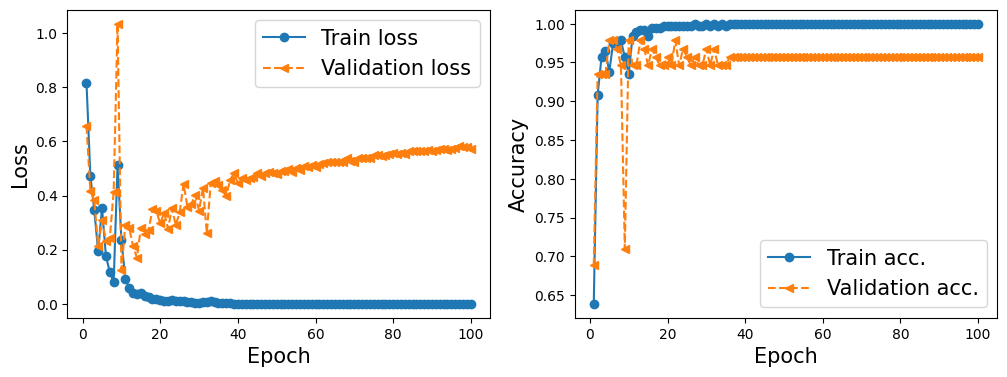

In [109]:
##### PLOTTING RESULTS #############
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
#plt.savefig('figures/14_13.png')
plt.show()
#####################################

In [110]:
# Save the trained model
torch.save(model.state_dict(), current_file_path + r'\EMG_trained.pth') #CHANGE